In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(70736, 14)
(17685, 14)


In [5]:
X_train = train_data.drop(columns=['No-show', 'AppointmentID', 'PatientId'])
y_train = train_data['No-show']

X_test = test_data.drop(columns=['No-show', 'AppointmentID', 'PatientId'])
y_test = test_data['No-show']

# Preprocessing

## Conversione delle colonne datetime

In [6]:
X_train_date = X_train.astype({'ScheduledDay': 'datetime64[D]', 'AppointmentDay': 'datetime64[D]'})
X_test_date = X_test.astype({'ScheduledDay': 'datetime64[D]', 'AppointmentDay': 'datetime64[D]'})

In [7]:
X_train_datediff = X_train_date['AppointmentDay'] - X_train_date['ScheduledDay']
X_test_datediff = X_test_date['AppointmentDay'] - X_test_date['ScheduledDay']

In [8]:
X_train_datediff = X_train_datediff.astype('timedelta64[D]')
X_test_datediff = X_test_datediff.astype('timedelta64[D]')
X_train_datediff = X_train_datediff.astype('int64')
X_test_datediff = X_test_datediff.astype('int64')
X_test_datediff

0         2
1        32
2         0
3        14
4        21
         ..
17680     0
17681    22
17682     1
17683    23
17684     0
Length: 17685, dtype: int64

In [9]:
X_train_daydiff = X_train_date.drop(columns=['ScheduledDay', 'AppointmentDay'])
X_train_daydiff['DaysToAppointment'] = X_train_datediff

X_test_daydiff = X_test_date.drop(columns=['ScheduledDay', 'AppointmentDay'])
X_test_daydiff['DaysToAppointment'] = X_test_datediff

In [10]:
X_train_daydiff = X_train_daydiff.drop(columns=['Gender'])
X_test_daydiff = X_test_daydiff.drop(columns=['Gender'])

In [11]:
X_train_daydiff.dtypes

Age                   int64
Neighbourhood        object
Scholarship           int64
Hipertension          int64
Diabetes              int64
Alcoholism            int64
Handcap               int64
SMS_received          int64
DaysToAppointment     int64
dtype: object

In [12]:
X_train_daydiff

,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,DaysToAppointment
0,21,SÃO CRISTÓVÃO,0,0,0,0,0,0,0
1,95,CENTRO,0,1,0,0,0,0,1
2,71,CRUZAMENTO,0,0,0,0,0,0,1
3,18,CARATOÍRA,0,0,0,0,0,0,2
4,45,PRAIA DO SUÁ,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
70731,30,ITARARÉ,0,1,0,0,0,1,8
70732,1,SANTA MARTHA,0,0,0,0,0,0,0
70733,43,JARDIM CAMBURI,0,0,0,0,0,1,61
70734,17,VILA RUBIM,0,0,0,0,0,0,2


## Codifica delle classi di Neighbourhood

In caso di classe poco frequente essa viene codificata con "Other", questo anche per i dati di test, così da evitare possibili errori nel LabelEncoding per nuove classi non viste in precedenza (nel fit).

In [13]:
X_train_temp = X_train_daydiff.drop(columns=['Neighbourhood'])
X_test_temp = X_test_daydiff.drop(columns=['Neighbourhood'])

# LabelEncoding

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
#X_train_date['Neighbourhood'] = le.fit_transform(X_train_daydiff['Neighbourhood'])
#X_train_date['Neighbourhood'].head(10)

In [16]:
#le.classes_

In [17]:
#X_test_label = le.transform(X_test_date['Neighbourhood'])

# Scelta dei modelli, training e fit

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier

In [19]:
X_train = X_train_temp
X_test = X_test_temp

In [20]:
models_to_train = [DecisionTreeClassifier(), LogisticRegression(), RandomForestClassifier()]

In [21]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        #('label', LabelEncoder()),
        ('model', DecisionTreeClassifier())
        ])

In [22]:
pipe = pipe.fit(X_train, y_train)
print('Score finale di test: ', pipe.score(X_test, y_test))

Score finale di test:  0.7705965507492225


In [24]:
params = [
            {'model': [DecisionTreeClassifier()],
            'model__max_depth': np.arange(1,41)},
            {'model': [LogisticRegression()],
            'model__max_iter': [2000],
            'model__penalty': ['l2'], #[['l1', 'l2']]
            'model__C': np.logspace(0, 4, 10)},
            {'model': [RandomForestClassifier()],
            'model__n_estimators': [10, 200, 1000],
            'model__max_features': np.arange(1,10)}
            ]

In [25]:
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(pipe, params, cv=2, verbose=1).fit(X_train, y_train) #specificare cv=5
print('Score finale di test: ', gridsearch.score(X_test, y_test))

Fitting 2 folds for each of 77 candidates, totalling 154 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\python3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\python3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\python3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "c:\python3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\python3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\python3\lib\site-pac

c:\python3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\python3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\python3\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "c:\python3\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\python3\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\python3\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = self._backend.apply_a

Score finale di test:  0.7918575063613231


In [26]:
gridsearch.best_estimator_.get_params()

{'memory': None,
 'steps': [('model', DecisionTreeClassifier(max_depth=3))],
 'verbose': False,
 'model': DecisionTreeClassifier(max_depth=3),
 'model__ccp_alpha': 0.0,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': 3,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_impurity_split': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'model__presort': 'deprecated',
 'model__random_state': None,
 'model__splitter': 'best'}

## DecisionTree

In [27]:
max_loop_depth = 40
max_score = 0
best_depth = 0

for depth in range(1, max_loop_depth):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if(score > max_score):
        max_score = score
        best_depth = depth
    
best_model = DecisionTreeClassifier(max_depth=best_depth, random_state=1)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

Text(0.5, 1.0, 'DecisionTreeClassifier feature importance')

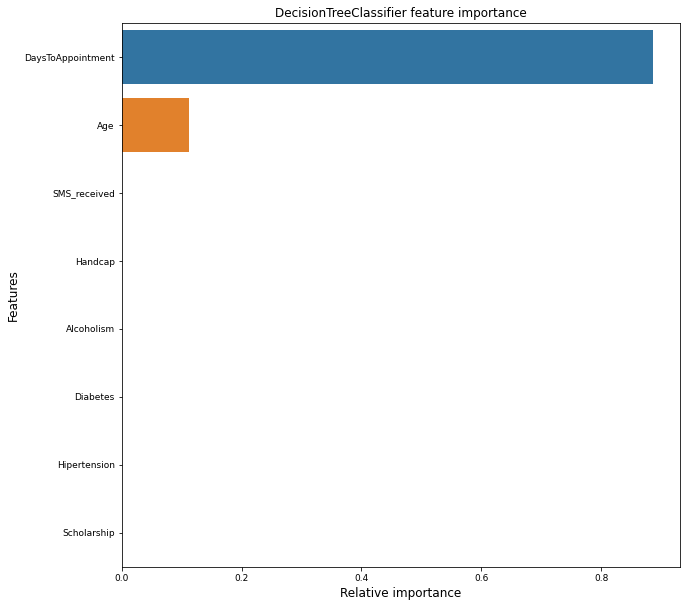

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(10,10))

indices = np.argsort(best_model.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = best_model.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title('DecisionTreeClassifier' + " feature importance")

In [29]:
print('Training Accuracy: ', best_model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', best_model.score(X_test, y_test) * 100, '%')

Training Accuracy:  79.92676996154717 %
Testing Accuracy:  79.18575063613231 %


## LogisticRegression

In [30]:
model = LogisticRegression(max_iter=1000, random_state=1)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1)

In [31]:
print('Training Accuracy: ', model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', model.score(X_test, y_test) * 100, '%')

Training Accuracy:  79.59596245193396 %
Testing Accuracy:  78.77297144472718 %


## RandomForest

In [32]:
model = RandomForestClassifier(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

Text(0.5, 1.0, 'RandomForestClassifier feature importance')

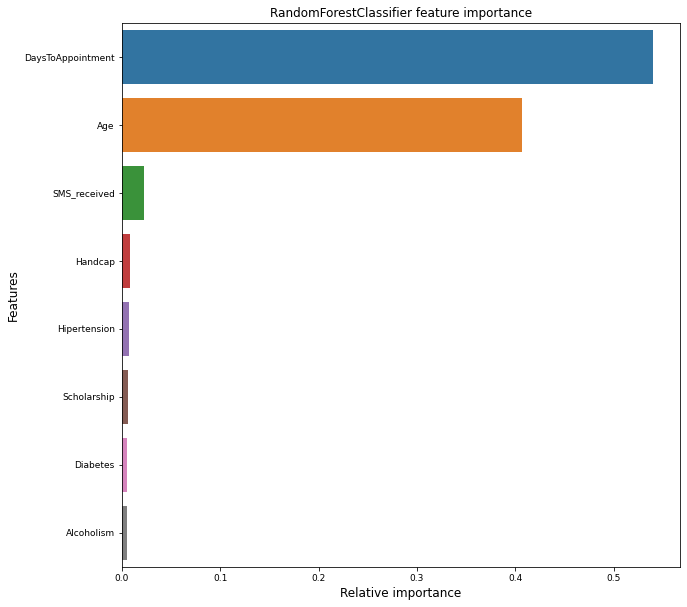

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(10,10))

indices = np.argsort(model.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = model.feature_importances_[indices][:40] , orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title('RandomForestClassifier' + " feature importance")

In [34]:
print('Training Accuracy: ', model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', model.score(X_test, y_test) * 100, '%')

Training Accuracy:  85.92937118299028 %
Testing Accuracy:  76.75431156347187 %
